To evaluate the performance of the model, we calculate the Mean Squared Error. For GAN, we calculate MSE between the generated and actual stock prices. However, GANs are generative models and not optimized for predictive tasks, so the evaluation might not be as meaningful as with other models like LSTMs.

Hence, even the MSEs of GAN are better, the prediction result of LSTM is better.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv1DTranspose, Conv1D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random

In [ ]:
d1 = pd.read_csv('/content/drive/MyDrive/BT5153 project/sentiment-flair model.csv')
d2 = pd.read_csv('/content/drive/MyDrive/BT5153 project/stock_yfinance_data.csv')

In [ ]:
print(d1.info())
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          80793 non-null  int64  
 1   Date                80793 non-null  object 
 2   Tweet               80793 non-null  object 
 3   Stock Name          80793 non-null  object 
 4   Company Name        80793 non-null  object 
 5   time                80793 non-null  object 
 6   preprocessed_tweet  80793 non-null  object 
 7   probability         80793 non-null  float64
 8   sentiment           80793 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 5.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6300 non-null   object 
 1   Open        6300 non-null   float64
 2   High       

In [ ]:
# Preprocess datasets
d1['Date'] = pd.to_datetime(d1['Date'])
d2['Date'] = pd.to_datetime(d2['Date'])

# Merge datasets on Date and Stock Name
data = pd.merge(d1, d2, on=['Date', 'Stock Name'])

# Filter for TSLA and AMZN
tsla_data = data[data['Stock Name'] == 'TSLA']
amzn_data = data[data['Stock Name'] == 'AMZN']

In [ ]:
print('TSLA: \n')
print(tsla_data.head())
print('AMZN: \n')
print(amzn_data.head())

TSLA: 

   Unnamed: 0       Date                                              Tweet  \
0           0 2022-09-29  Mainstream media has done an amazing job at br...   
1           1 2022-09-29  Tesla delivery estimates are at around 364k fr...   
2           2 2022-09-29  3/ Even if I include 63.0M unvested RSUs as of...   
3           3 2022-09-29  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4           4 2022-09-29  @RealDanODowd @Tesla Stop trying to kill kids,...   

  Stock Name Company Name      time  \
0       TSLA  Tesla, Inc.  23:41:16   
1       TSLA  Tesla, Inc.  23:24:43   
2       TSLA  Tesla, Inc.  23:18:08   
3       TSLA  Tesla, Inc.  22:40:07   
4       TSLA  Tesla, Inc.  22:27:05   

                                  preprocessed_tweet  probability sentiment  \
0  mainstream media has done an amazing job at br...     0.900826  POSITIVE   
1  tesla delivery estimates are at around 364k fr...     0.987166  NEGATIVE   
2  3 even if i include 630m unvested rsus as 

# **LSTM**


---


*   By date





In [ ]:
# Define a function to preprocess stock data for LSTM
def preprocess_stock_data(df):
    df = df[['Date', 'Close', 'Volume', 'probability']]
    df.set_index('Date', inplace=True)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_scaled, scaler

tsla_scaled, tsla_scaler = preprocess_stock_data(tsla_data)
amzn_scaled, amzn_scaler = preprocess_stock_data(amzn_data)


In [ ]:
#Prepare the data for LSTM
def prepare_data(data, lookback):
    X, y, dates = [], [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i, 0])  # Close price
        dates.append(data.index[i])  # Store the date
    return np.array(X), np.array(y), dates

lookback = 60
X_tsla, y_tsla, dates_tsla = prepare_data(tsla_scaled, lookback)
X_amzn, y_amzn, dates_amzn = prepare_data(amzn_scaled, lookback)


In [ ]:
#Split the data into training and testing sets
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla, dates_train_tsla, dates_test_tsla = train_test_split(X_tsla, y_tsla, dates_tsla, test_size=0.2, shuffle=False)
X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn, dates_train_amzn, dates_test_amzn = train_test_split(X_amzn, y_amzn, dates_amzn, test_size=0.2, shuffle=False)


In [ ]:
#Build the LSTM model:
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_tsla = build_lstm_model(X_train_tsla.shape[1:])
model_amzn = build_lstm_model(X_train_amzn.shape[1:])


In [ ]:
#Train the LSTM model:
epochs = 50
batch_size = 32

history_tsla = model_tsla.fit(X_train_tsla, y_train_tsla, epochs=epochs, batch_size=batch_size, validation_data=(X_test_tsla, y_test_tsla))
history_amzn = model_amzn.fit(X_train_amzn, y_train_amzn, epochs=epochs, batch_size=batch_size, validation_data=(X_test_amzn, y_test_amzn))


In [ ]:
#Evaluate the LSTM model
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), X_test.shape[2] - 1))]))[:, 0]
    y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), X_test.shape[2] - 1))]))[:, 0]
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    return mse, y_test_inv, y_pred_inv

mse_tsla, y_test_tsla_inv, y_pred_tsla_inv = evaluate_model(model_tsla, X_test_tsla, y_test_tsla, tsla_scaler)
mse_amzn, y_test_amzn_inv, y_pred_amzn_inv = evaluate_model(model_amzn, X_test_amzn, y_test_amzn, amzn_scaler)

print(f'TSLA Mean Squared Error: {mse_tsla}')
print(f'AMZN Mean Squared Error: {mse_amzn}')


21/21 [==============================] - 1s 5ms/step
TSLA Mean Squared Error: 4.782268258354032
AMZN Mean Squared Error: 11.914857904610239


In [ ]:
def plot_predictions(y_test, y_pred, stock_name, dates):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, y_test, color='blue', label='Actual')
    plt.plot(dates, y_pred, color='red', label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


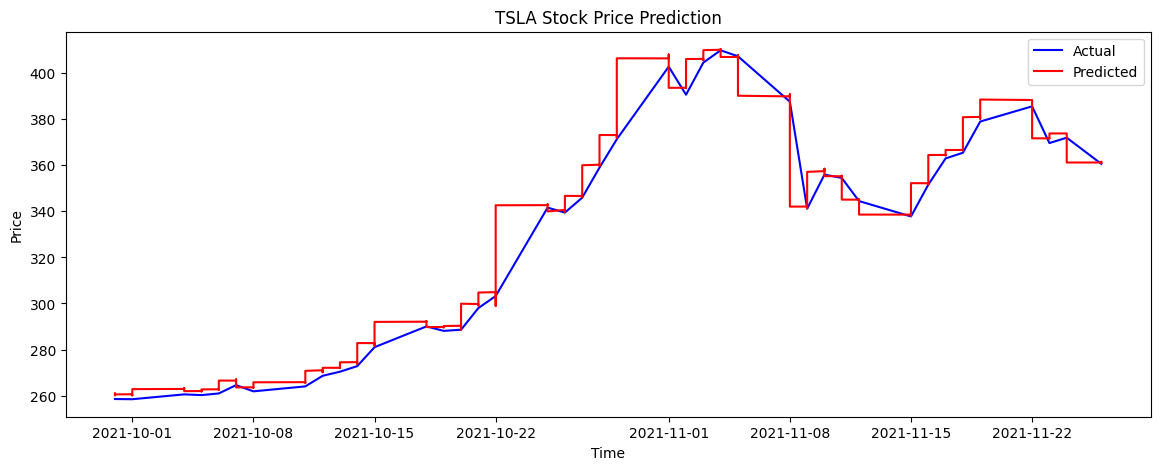

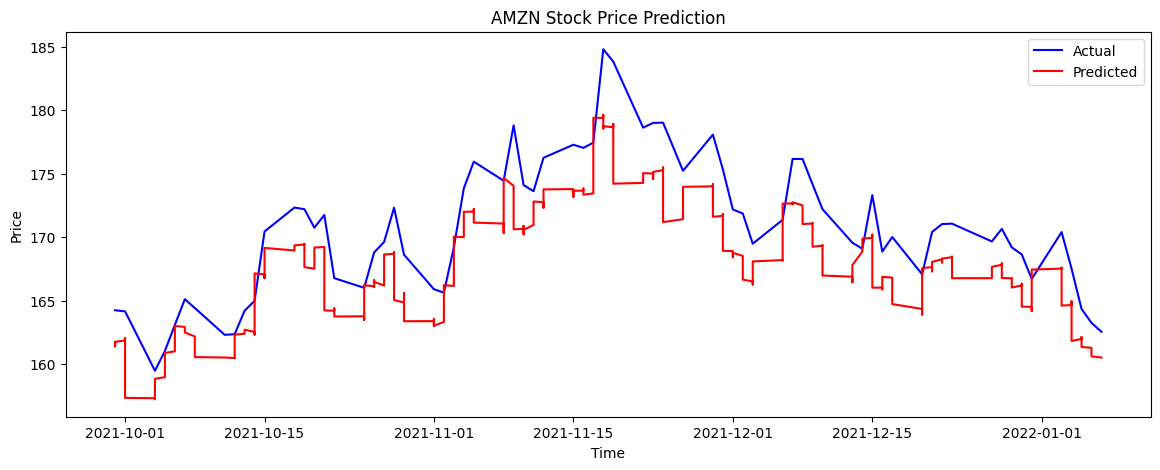

In [ ]:
plot_predictions(y_test_tsla_inv, y_pred_tsla_inv, 'TSLA', dates_test_tsla)
plot_predictions(y_test_amzn_inv, y_pred_amzn_inv, 'AMZN', dates_test_amzn)


#**LSTM**


---


*   By time steps





In [ ]:
#Prepare the data for LSTM
def prepare_data2(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i, 0])  # Close price
    return np.array(X), np.array(y)

lookback = 60
X_tsla2, y_tsla2 = prepare_data2(tsla_scaled, lookback)
X_amzn2, y_amzn2 = prepare_data2(amzn_scaled, lookback)


In [ ]:
#Split the data into training and testing sets
X_train_tsla2, X_test_tsla2, y_train_tsla2, y_test_tsla2 = train_test_split(X_tsla2, y_tsla2, test_size=0.2, shuffle=False)
X_train_amzn2, X_test_amzn2, y_train_amzn2, y_test_amzn2 = train_test_split(X_amzn2, y_amzn2, test_size=0.2, shuffle=False)


In [ ]:
#Build the LSTM model:
model_tsla2 = build_lstm_model(X_train_tsla2.shape[1:])
model_amzn2 = build_lstm_model(X_train_amzn2.shape[1:])

In [ ]:
#Train the LSTM model:
epochs = 50
batch_size = 32

history_tsla2 = model_tsla2.fit(X_train_tsla2, y_train_tsla2, epochs=epochs, batch_size=batch_size, validation_data=(X_test_tsla2, y_test_tsla2))
history_amzn2 = model_amzn2.fit(X_train_amzn2, y_train_amzn2, epochs=epochs, batch_size=batch_size, validation_data=(X_test_amzn2, y_test_amzn2))

In [ ]:
#Evaluate the LSTM model
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), X_test.shape[2] - 1))]))[:, 0]
    y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), X_test.shape[2] - 1))]))[:, 0]
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    return mse, y_test_inv, y_pred_inv

mse_tsla2, y_test_tsla_inv2, y_pred_tsla_inv2 = evaluate_model(model_tsla2, X_test_tsla2, y_test_tsla2, tsla_scaler)
mse_amzn2, y_test_amzn_inv2, y_pred_amzn_inv2 = evaluate_model(model_amzn2, X_test_amzn2, y_test_amzn2, amzn_scaler)

print(f'TSLA Mean Squared Error: {mse_tsla2}')
print(f'AMZN Mean Squared Error: {mse_amzn2}')


21/21 [==============================] - 1s 5ms/step
TSLA Mean Squared Error: 11.170688303680803
AMZN Mean Squared Error: 5.968118330262789


In [ ]:
#Plot the predictions:
def plot_predictions2(y_test, y_pred, stock_name):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, color='red', label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


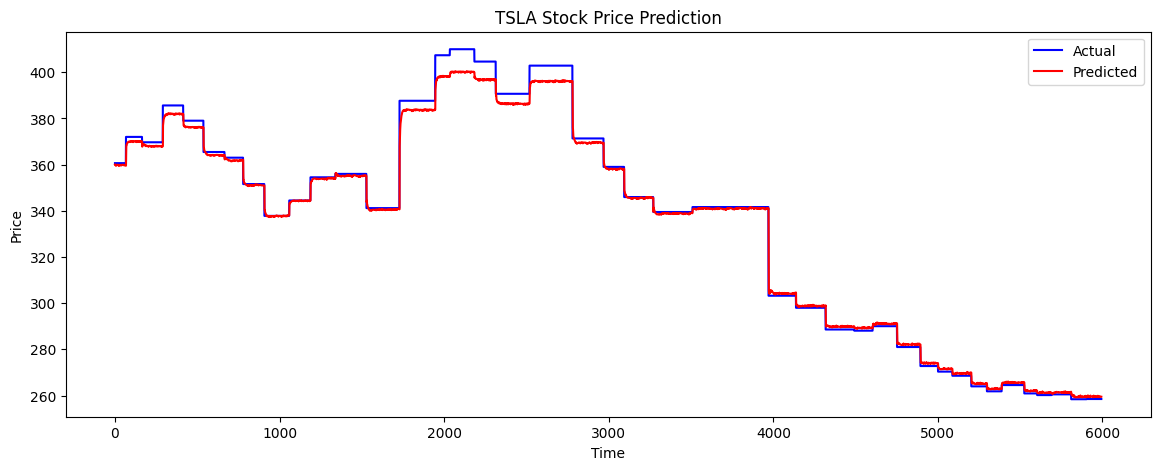

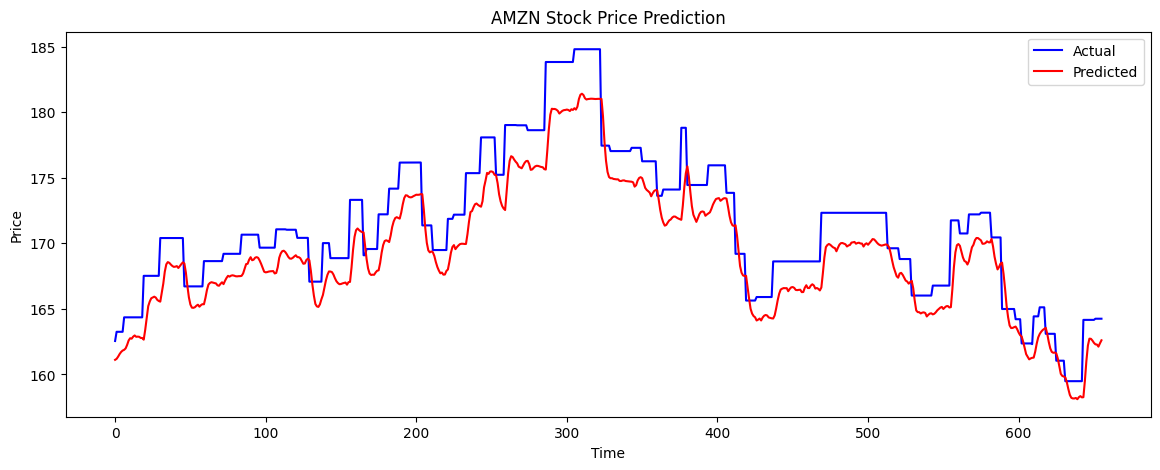

In [ ]:
plot_predictions2(y_test_tsla_inv2, y_pred_tsla_inv2, 'TSLA')
plot_predictions2(y_test_amzn_inv2, y_pred_amzn_inv2, 'AMZN')


In the predictions plot, "Time" represents the index or order of the test data points used for the prediction. The time steps don't necessarily correspond to specific dates, but rather show the order in which the test data was used for evaluating the model's performance.

The test data is not shuffled before splitting, so the time steps in the plot are in chronological order. The plot is used to visualize how well the LSTM model's predictions match the actual stock prices over the given test data sequence.

**Hyperparameter Tuning: Random Search**


*   by date




In [ ]:
#Create a KerasRegressor wrapper for the LSTM model
lstm_regressor = KerasRegressor(build_fn=build_lstm_model, input_shape=X_train_tsla.shape[1:], epochs=50, batch_size=32, verbose=0)

<ipython-input-105-2058b7afbb73>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=build_lstm_model, input_shape=X_train_tsla.shape[1:], epochs=50, batch_size=32, verbose=0)


In [ ]:
#Define the hyperparameter search space
param_dist = {
    'lstm_units': [30, 50, 70, 100],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
}

In [ ]:
#Create the RandomizedSearchCV instance
random_search = RandomizedSearchCV(estimator=lstm_regressor, param_distributions=param_dist, n_iter=3, cv=3, n_jobs=-1, verbose=2, random_state=42)

In [ ]:
#Perform the random search for TSLA
random_search_result = random_search.fit(X_train_tsla, y_train_tsla)

In [ ]:
#Check the best hyperparameters for TSLA
print("Best score: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Best score: -0.000109 using {'lstm_units': 30, 'dropout_rate': 0.1}


In [ ]:
#Perform the random search for AMZN
random_search_result_2 = random_search.fit(X_train_amzn, y_train_amzn)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
#Check the best hyperparameters for AMZN
print("Best score: %f using %s" % (random_search_result_2.best_score_, random_search_result_2.best_params_))

Best score: -0.000539 using {'lstm_units': 100, 'dropout_rate': 0.4}


In [ ]:
best_lstm_units = random_search_result.best_params_['lstm_units']
best_dropout_rate = random_search_result.best_params_['dropout_rate']
best_lstm_units_2 = random_search_result_2.best_params_['lstm_units']
best_dropout_rate_2 = random_search_result_2.best_params_['dropout_rate']


In [ ]:
#train model with the best hyperparameters
best_model_tsla = build_lstm_model(X_train_tsla.shape[1:], lstm_units=best_lstm_units, dropout_rate=best_dropout_rate)
best_history_tsla = best_model_tsla.fit(X_train_tsla, y_train_tsla, epochs=50, batch_size=32, validation_data=(X_test_tsla, y_test_tsla))

best_model_amzn = build_lstm_model(X_train_amzn.shape[1:], lstm_units=best_lstm_units_2, dropout_rate=best_dropout_rate_2)
best_history_amzn = best_model_amzn.fit(X_train_amzn, y_train_amzn, epochs=50, batch_size=32, validation_data=(X_test_amzn, y_test_amzn))


In [ ]:
mse_best_tsla, y_test_best_tsla_inv, y_pred_best_tsla_inv = evaluate_model(best_model_tsla, X_test_tsla, y_test_tsla, tsla_scaler)
print(f'TSLA Mean Squared Error (Best Model): {mse_best_tsla}')
mse_best_amzn, y_test_best_amzn_inv, y_pred_best_amzn_inv = evaluate_model(best_model_amzn, X_test_amzn, y_test_amzn, amzn_scaler)
print(f'AMZN Mean Squared Error (Best Model): {mse_best_amzn}')


188/188 [==============================] - 2s 5ms/step
TSLA Mean Squared Error (Best Model): 4.798562300988784
21/21 [==============================] - 1s 5ms/step
AMZN Mean Squared Error (Best Model): 2.437081279695965


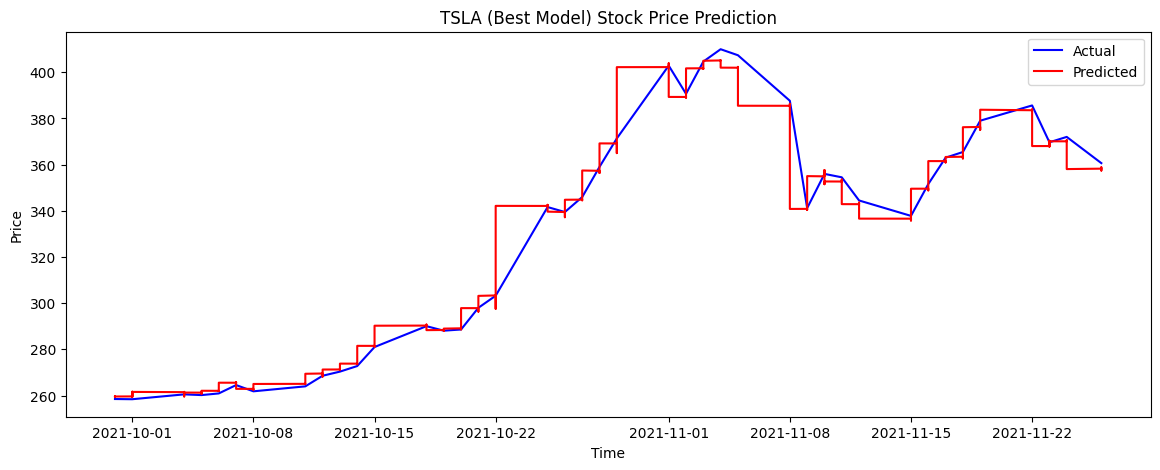

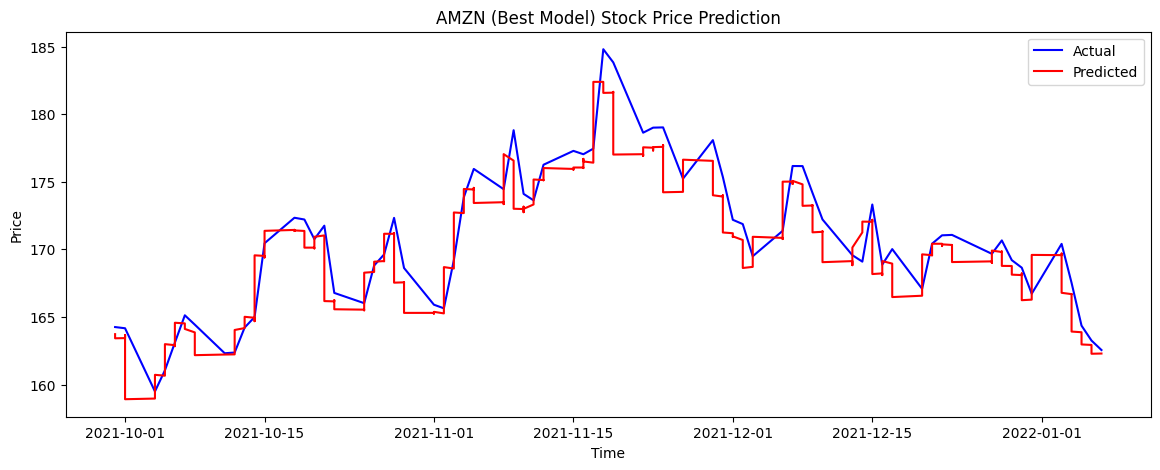

In [ ]:
plot_predictions(y_test_best_tsla_inv, y_pred_best_tsla_inv, 'TSLA (Best Model)', dates_test_tsla)
plot_predictions(y_test_best_amzn_inv, y_pred_best_amzn_inv, 'AMZN (Best Model)', dates_test_amzn)

**Hyperparameter Tuning: Random Search**


*   by time steps


In [ ]:
#Create a KerasRegressor wrapper for the LSTM model
lstm_regressor2 = KerasRegressor(build_fn=build_lstm_model, input_shape=X_train_tsla2.shape[1:], epochs=50, batch_size=32, verbose=0)

#Create the RandomizedSearchCV instance
random_search2 = RandomizedSearchCV(estimator=lstm_regressor2, param_distributions=param_dist, n_iter=3, cv=3, n_jobs=-1, verbose=2, random_state=42)

<ipython-input-117-083cfa65d8c0>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor2 = KerasRegressor(build_fn=build_lstm_model, input_shape=X_train_tsla2.shape[1:], epochs=50, batch_size=32, verbose=0)


In [ ]:
#Perform the random search for TSLA
random_search_result2 = random_search2.fit(X_train_tsla2, y_train_tsla2)

#Check the best hyperparameters TSLA
print("Best score: %f using %s" % (random_search_result2.best_score_, random_search_result2.best_params_))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best score: -0.000088 using {'lstm_units': 30, 'dropout_rate': 0.1}


In [ ]:
#Perform the random search for AMZN
random_search_result2_2 = random_search2.fit(X_train_amzn2, y_train_amzn2)

#Check the best hyperparameters for AMZN
print("Best score: %f using %s" % (random_search_result2_2.best_score_, random_search_result2_2.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best score: -0.000642 using {'lstm_units': 30, 'dropout_rate': 0.1}


In [ ]:
best_lstm_units2 = random_search_result2.best_params_['lstm_units']
best_dropout_rate2 = random_search_result2.best_params_['dropout_rate']
best_lstm_units2_2 = random_search_result2_2.best_params_['lstm_units']
best_dropout_rate2_2 = random_search_result2_2.best_params_['dropout_rate']

best_model_tsla2 = build_lstm_model(X_train_tsla2.shape[1:], lstm_units=best_lstm_units2, dropout_rate=best_dropout_rate2)
best_history_tsla2 = best_model_tsla2.fit(X_train_tsla2, y_train_tsla2, epochs=50, batch_size=32, validation_data=(X_test_tsla2, y_test_tsla2))

best_model_amzn2 = build_lstm_model(X_train_amzn2.shape[1:], lstm_units=best_lstm_units2_2, dropout_rate=best_dropout_rate2_2)
best_history_amzn2 = best_model_amzn2.fit(X_train_amzn2, y_train_amzn2, epochs=50, batch_size=32, validation_data=(X_test_amzn2, y_test_amzn2))

188/188 [==============================] - 1s 4ms/step
TSLA Mean Squared Error (Best Model): 4.798562300988784
21/21 [==============================] - 0s 4ms/step
AMZN Mean Squared Error (Best Model): 2.437081279695965


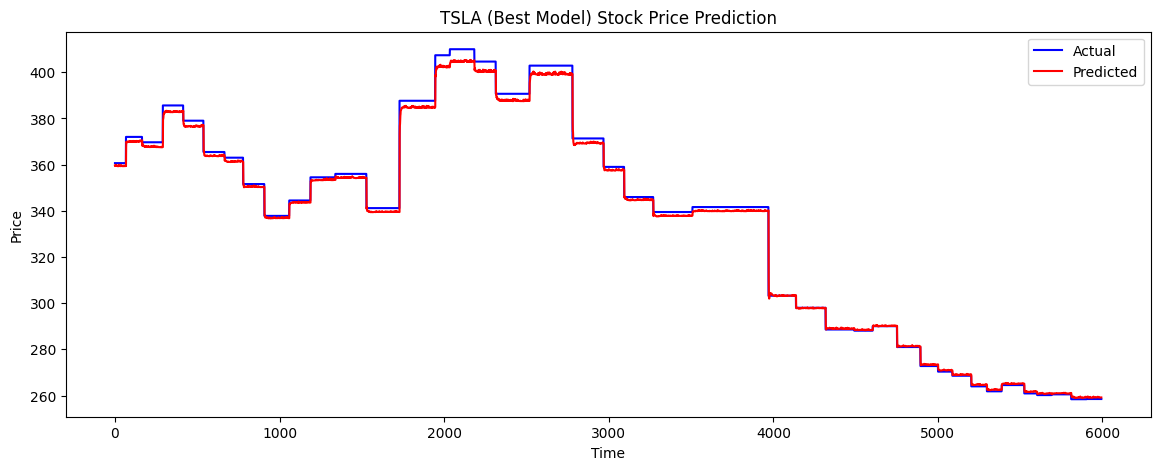

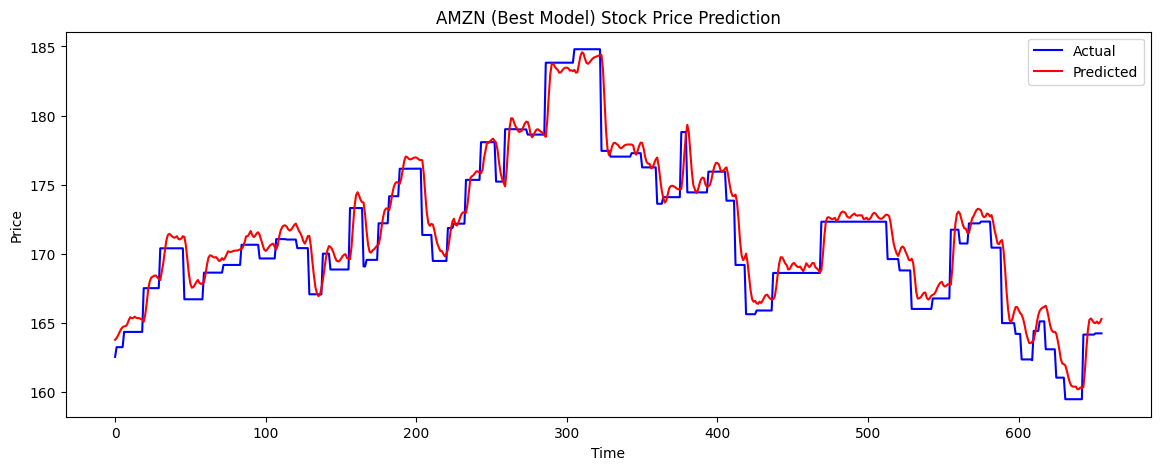

In [ ]:
mse_best_tsla2, y_test_best_tsla_inv2, y_pred_best_tsla_inv2 = evaluate_model(best_model_tsla2, X_test_tsla2, y_test_tsla2, tsla_scaler)
print(f'TSLA Mean Squared Error (Best Model): {mse_best_tsla}')
mse_best_amzn2, y_test_best_amzn_inv2, y_pred_best_amzn_inv2 = evaluate_model(best_model_amzn2, X_test_amzn2, y_test_amzn2, amzn_scaler)
print(f'AMZN Mean Squared Error (Best Model): {mse_best_amzn}')

plot_predictions2(y_test_best_tsla_inv2, y_pred_best_tsla_inv2, 'TSLA (Best Model)')
plot_predictions2(y_test_best_amzn_inv2, y_pred_best_amzn_inv2, 'AMZN (Best Model)')


# **GAN**

---



*   by date






In [ ]:
#define generator
def build_generator(latent_dim, output_shape):
    model = tf.keras.Sequential()

    model.add(Dense(128, activation=LeakyReLU(0.2), input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))

    noise = Input(shape=(latent_dim,))
    gen_data = model(noise)
    return Model(noise, gen_data)



In [ ]:
#define discriminator
def build_discriminator(input_shape):
    model = tf.keras.Sequential()

    model.add(Conv1D(32, kernel_size=4, strides=2, padding='same', input_shape=input_shape, activation=LeakyReLU(0.2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(64, kernel_size=4, strides=2, padding='same', activation=LeakyReLU(0.2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    data = Input(shape=input_shape)
    validity = model(data)
    return Model(data, validity)


In [ ]:
# Build the GANs model
def build_gan(generator, discriminator, learning_rate, latent_dim):
    discriminator.trainable = False
    noise = Input(shape=(latent_dim,))
    gen_data = generator(noise)
    validity = discriminator(gen_data)
    gan_model = Model(noise, validity)
    gan_model.compile(optimizer=Adam(learning_rate, 0.5), loss='binary_crossentropy')
    return gan_model



In [ ]:
#Define the training function
def train_gan(data, gan, generator, discriminator, latent_dim, epochs, batch_size):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    n_batches = data.shape[0] // batch_size

    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = data[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, valid)

        print(f'Epoch {epoch+1}: Discriminator loss: {d_loss[0]:.4f}, Generator loss: {g_loss:.4f}')


In [ ]:
#Train the GAN model
latent_dim = 100
epochs = 500
batch_size = 32
learning_rate = 5e-4

# Create the generator and discriminator models for TSLA and AMZN
generator = build_generator(latent_dim, X_train_tsla.shape[1:])
discriminator = build_discriminator(X_train_tsla.shape[1:])

generator2 = build_generator(latent_dim, X_train_amzn.shape[1:])
discriminator2 = build_discriminator(X_train_amzn.shape[1:])

# Compile the discriminator model
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create and compile the combined GAN model
gan = build_gan(generator, discriminator, learning_rate, latent_dim)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

gan2 = build_gan(generator2, discriminator2, learning_rate, latent_dim)
gan2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Train the GAN
train_gan(X_train_tsla, gan, generator, discriminator, latent_dim, epochs, batch_size)
train_gan(X_train_amzn, gan2, generator2, discriminator2, latent_dim, epochs, batch_size)


1/1 [==============================] - 3s 3s/step
Epoch 1: Discriminator loss: 0.9917, Generator loss: 0.6897
1/1 [==============================] - 0s 18ms/step
Epoch 2: Discriminator loss: 1.2045, Generator loss: 0.6912
1/1 [==============================] - 0s 18ms/step
Epoch 3: Discriminator loss: 0.9454, Generator loss: 0.6958
1/1 [==============================] - 0s 17ms/step
Epoch 4: Discriminator loss: 0.8098, Generator loss: 0.6977
1/1 [==============================] - 0s 16ms/step
Epoch 5: Discriminator loss: 0.9807, Generator loss: 0.6685
1/1 [==============================] - 0s 18ms/step
Epoch 6: Discriminator loss: 0.8388, Generator loss: 0.7519
1/1 [==============================] - 0s 16ms/step
Epoch 7: Discriminator loss: 0.9672, Generator loss: 0.8165
1/1 [==============================] - 0s 16ms/step
Epoch 8: Discriminator loss: 0.8380, Generator loss: 0.7546
1/1 [==============================] - 0s 16ms/step
Epoch 9: Discriminator loss: 0.7249, Generator loss: 0

In [ ]:
def generate_predictions(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    return generator.predict(noise)

gan_pred_tsla = generate_predictions(generator, latent_dim, len(X_test_tsla))
gan_pred_amzn = generate_predictions(generator2, latent_dim, len(X_test_amzn))

21/21 [==============================] - 0s 2ms/step


In [ ]:
gan_pred_tsla = generator.predict(np.random.normal(0, 1, (X_test_tsla.shape[0], latent_dim)))
print("y_test_tsla shape:", y_test_tsla.shape)
print("gan_pred_tsla shape:", gan_pred_tsla.shape)


188/188 [==============================] - 0s 1ms/step
y_test_tsla shape: (5994,)
gan_pred_tsla shape: (5994, 60, 3)


188/188 [==============================] - 0s 1ms/step
TSLA Mean Squared Error (GAN): 0.6889062949038355
21/21 [==============================] - 0s 1ms/step
AMZN Mean Squared Error (GAN): 0.7437832124450254


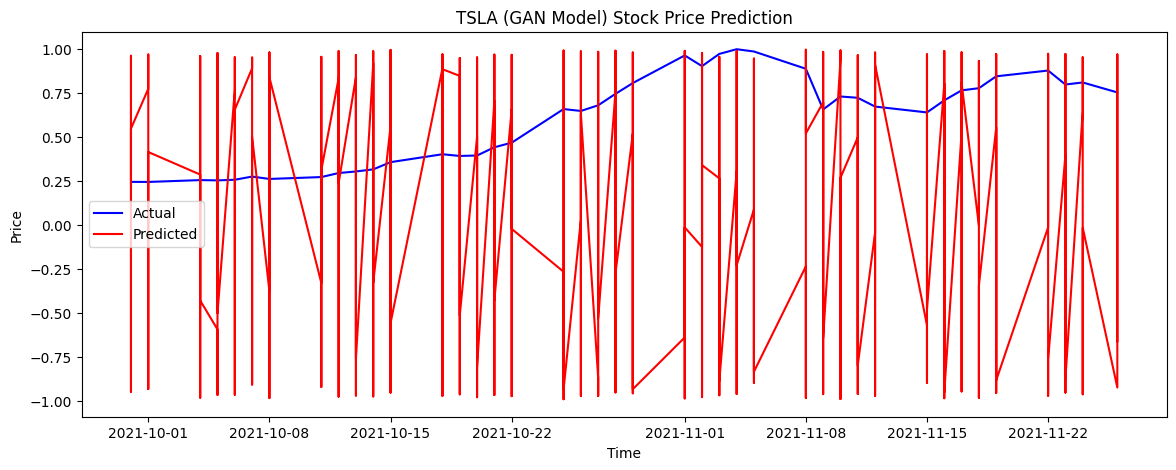

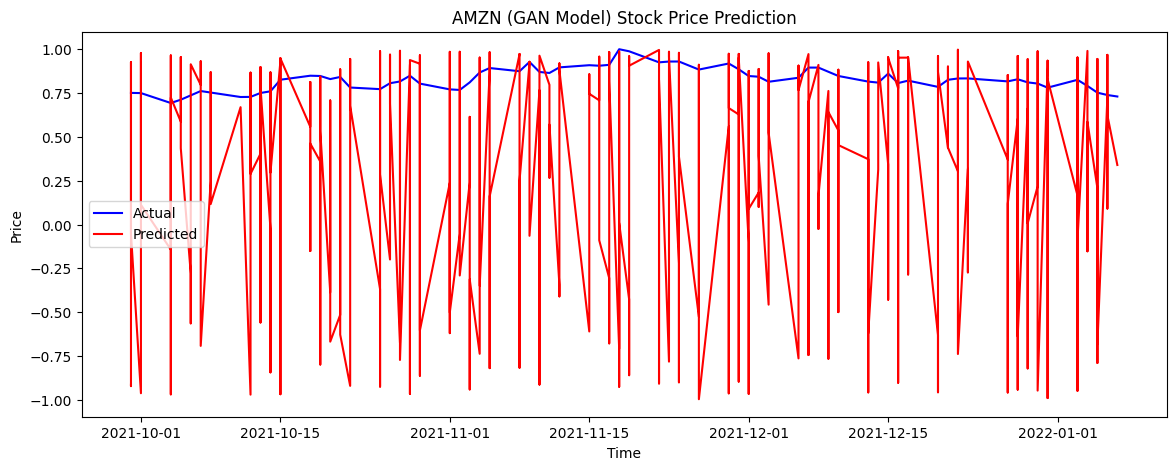

In [ ]:
gan_pred_tsla = generator.predict(np.random.normal(0, 1, (X_test_tsla.shape[0], latent_dim)))[:, -1, 0]
mse_gan_tsla = mean_squared_error(y_test_tsla, gan_pred_tsla)
print(f'TSLA Mean Squared Error (GAN): {mse_gan_tsla}')

gan_pred_amzn = generator2.predict(np.random.normal(0, 1, (X_test_amzn.shape[0], latent_dim)))[:, -1, 0]
mse_gan_amzn = mean_squared_error(y_test_amzn, gan_pred_amzn)
print(f'AMZN Mean Squared Error (GAN): {mse_gan_amzn}')

# Plot the predictions
plot_predictions(y_test_tsla, gan_pred_tsla, 'TSLA (GAN Model)', dates_test_tsla)
plot_predictions(y_test_amzn, gan_pred_amzn, 'AMZN (GAN Model)', dates_test_amzn)

# **GAN**


---



*   by time steps




In [ ]:
# Create the generator and discriminator models
generator_2 = build_generator(latent_dim, X_train_tsla2.shape[1:])
discriminator_2 = build_discriminator(X_train_tsla2.shape[1:])

generator2_2 = build_generator(latent_dim, X_train_amzn2.shape[1:])
discriminator2_2 = build_discriminator(X_train_amzn2.shape[1:])

# Compile the discriminator model
discriminator_2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator2_2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create and compile the combined GAN model
gan_2 = build_gan(generator_2, discriminator_2, learning_rate, latent_dim)
gan_2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

gan2_2 = build_gan(generator2_2, discriminator2_2, learning_rate, latent_dim)
gan2_2.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Train the GAN
train_gan(X_train_tsla2, gan_2, generator_2, discriminator_2, latent_dim, epochs, batch_size)
train_gan(X_train_amzn2, gan2_2, generator2_2, discriminator2_2, latent_dim, epochs, batch_size)


1/1 [==============================] - 0s 65ms/step
Epoch 1: Discriminator loss: 1.2053, Generator loss: 0.6832
1/1 [==============================] - 0s 19ms/step
Epoch 2: Discriminator loss: 1.0361, Generator loss: 0.6707
1/1 [==============================] - 0s 16ms/step
Epoch 3: Discriminator loss: 0.9640, Generator loss: 0.7168
1/1 [==============================] - 0s 18ms/step
Epoch 4: Discriminator loss: 1.0099, Generator loss: 0.7186
1/1 [==============================] - 0s 16ms/step
Epoch 5: Discriminator loss: 0.9540, Generator loss: 0.6944
1/1 [==============================] - 0s 18ms/step
Epoch 6: Discriminator loss: 1.0542, Generator loss: 0.6460
1/1 [==============================] - 0s 17ms/step
Epoch 7: Discriminator loss: 0.9836, Generator loss: 0.6285
1/1 [==============================] - 0s 17ms/step
Epoch 8: Discriminator loss: 1.0681, Generator loss: 0.7060
1/1 [==============================] - 0s 23ms/step
Epoch 9: Discriminator loss: 0.7093, Generator loss:

In [ ]:
gan_pred_tsla2 = generate_predictions(generator_2, latent_dim, len(X_test_tsla2))
gan_pred_amzn2 = generate_predictions(generator2_2, latent_dim, len(X_test_amzn2))

21/21 [==============================] - 0s 1ms/step


In [ ]:
gan_pred_tsla2 = generator_2.predict(np.random.normal(0, 1, (X_test_tsla.shape[0], latent_dim)))
print("y_test_tsla2 shape:", y_test_tsla2.shape)
print("gan_pred_tsla2 shape:", gan_pred_tsla2.shape)

188/188 [==============================] - 0s 1ms/step
y_test_tsla2 shape: (5994,)
gan_pred_tsla2 shape: (5994, 60, 3)


In [ ]:
gan_pred_tsla2 = generator_2.predict(np.random.normal(0, 1, (X_test_tsla2.shape[0], latent_dim)))[:, -1, 0]
mse_gan_tsla2 = mean_squared_error(y_test_tsla2, gan_pred_tsla2)
print(f'TSLA Mean Squared Error (GAN): {mse_gan_tsla2}')

gan_pred_amzn2 = generator2_2.predict(np.random.normal(0, 1, (X_test_amzn2.shape[0], latent_dim)))[:, -1, 0]
mse_gan_amzn2 = mean_squared_error(y_test_amzn2, gan_pred_amzn2)
print(f'AMZN Mean Squared Error (GAN): {mse_gan_amzn2}')


188/188 [==============================] - 0s 1ms/step
TSLA Mean Squared Error (GAN): 0.5995390601268953
21/21 [==============================] - 0s 1ms/step
AMZN Mean Squared Error (GAN): 0.8710652367784602


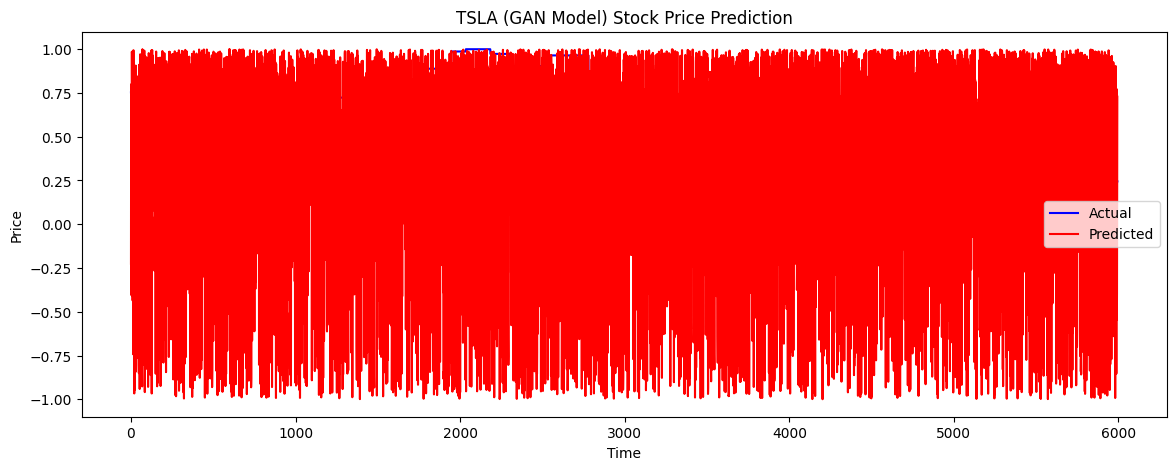

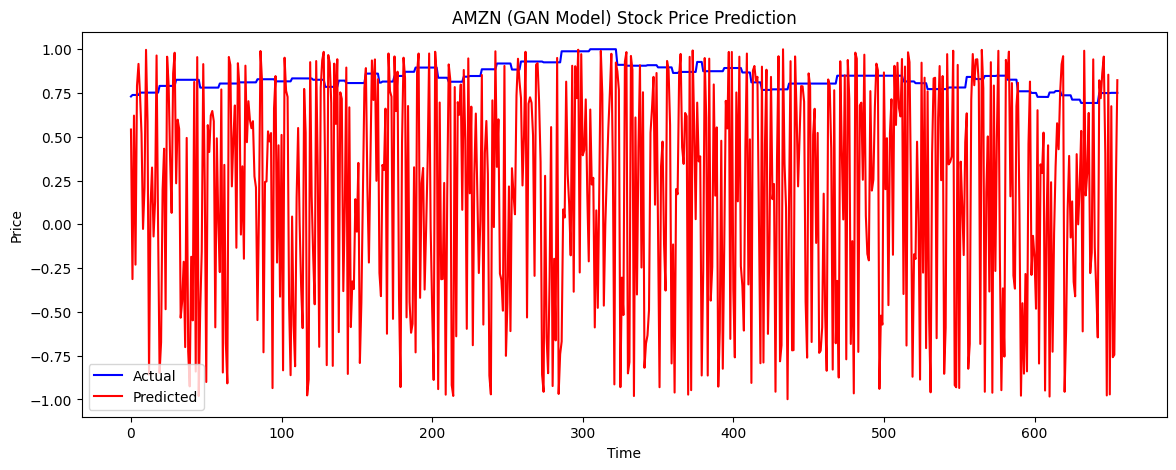

In [ ]:
# Plot the predictions
plot_predictions2(y_test_tsla2, gan_pred_tsla2, 'TSLA (GAN Model)')
plot_predictions2(y_test_amzn2, gan_pred_amzn2, 'AMZN (GAN Model)')

**Random Search**

In [ ]:
search_space = {
    'learning_rate': [5e-4, 5e-3, 5e-2],
    'batch_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'num_units': [64, 128, 256],
}


In [ ]:

def build_generator(latent_dim, output_shape, num_layers, num_units):
    model = Sequential()
    
    model.add(Dense(num_units, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))

    return model

def build_discriminator(input_shape, num_layers, num_units):
    model = Sequential()

    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(num_units))
    model.add(LeakyReLU(alpha=0.2))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units))
        model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))

    return model



In [ ]:
def train_gan_with_hyperparameters(hyperparams, X_train, y_train, X_test, y_test):
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    num_layers = hyperparams['num_layers']
    num_units = hyperparams['num_units']
    
    # Modify the build_generator and build_discriminator functions to accept num_layers and num_units as arguments
    generator = build_generator(latent_dim, X_train.shape[1:], num_layers, num_units)
    discriminator = build_discriminator(X_train.shape[1:], num_layers, num_units)
    
    # Compile the discriminator model
    discriminator.compile(optimizer=Adam(learning_rate, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Create and compile the GAN model with the given learning rate
    gan = build_gan(generator, discriminator, learning_rate, latent_dim)
    gan.compile(optimizer=Adam(learning_rate, 0.5), loss='binary_crossentropy')
    
    # Train the GAN with the given batch size and other parameters
    epochs = 100  # Adjust this value based on your requirements
    train_gan(X_train, gan, generator, discriminator, latent_dim, epochs, batch_size)
    
    # Evaluate the model on the test data and return the performance metric (e.g., MSE)
    gan_pred = generator.predict(np.random.normal(0, 1, (X_test.shape[0], latent_dim)))[:, -1, 0]  # Change this line
    mse = mean_squared_error(y_test, gan_pred)

    # Return the mean squared error and the trained generator model
    return mse, generator


By date

In [ ]:
#for TSLA
def random_search(iterations, search_space):
    best_mse = float('inf')
    best_hyperparams = None

    for _ in range(iterations):
        # Randomly select hyperparameters from search_space
        hyperparams = {
            key: random.choice(values) for key, values in search_space.items()
        }

        print(f'Training with hyperparameters: {hyperparams}')

        # Train and evaluate GAN model with the selected hyperparameters
        mse = train_gan_with_hyperparameters(hyperparams, X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla)[0]

        # Update the best hyperparameters if necessary
        if mse < best_mse:
            best_mse = mse
            best_hyperparams = hyperparams

        print(f'Current best hyperparameters: {best_hyperparams}')
        print(f'Current best MSE: {best_mse}')

    return best_hyperparams

# Perform random search
iterations = 5
best_hyperparams = random_search(iterations, search_space)

print(f'Best hyperparameters: {best_hyperparams}')



Training with hyperparameters: {'learning_rate': 0.005, 'batch_size': 32, 'num_layers': 2, 'num_units': 64}
1/1 [==============================] - 0s 81ms/step
Epoch 1: Discriminator loss: 0.7407, Generator loss: 0.5333
1/1 [==============================] - 0s 18ms/step
Epoch 2: Discriminator loss: 0.4059, Generator loss: 0.6111
1/1 [==============================] - 0s 16ms/step
Epoch 3: Discriminator loss: 0.3038, Generator loss: 0.7909
1/1 [==============================] - 0s 21ms/step
Epoch 4: Discriminator loss: 0.2473, Generator loss: 0.9543
1/1 [==============================] - 0s 20ms/step
Epoch 5: Discriminator loss: 0.2304, Generator loss: 1.2018
1/1 [==============================] - 0s 20ms/step
Epoch 6: Discriminator loss: 0.1863, Generator loss: 1.5585
1/1 [==============================] - 0s 20ms/step
Epoch 7: Discriminator loss: 0.1401, Generator loss: 1.9018
1/1 [==============================] - 0s 20ms/step
Epoch 8: Discriminator loss: 0.1857, Generator loss: 2.2

In [ ]:
# Train the GAN with the best hyperparameters and obtain the MSE and the trained generator model
mse_tsla, trained_generator_tsla = train_gan_with_hyperparameters(best_hyperparams, X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla)

# Generate predictions for TSLA
gan_pred_tsla = trained_generator_tsla.predict(np.random.normal(0, 1, (X_test_tsla.shape[0], latent_dim)))[:, -1, 0]

# Print the Mean Squared Errors
print(f"MSE for TSLA predictions: {mse_tsla}")

1/1 [==============================] - 0s 84ms/step
Epoch 1: Discriminator loss: 0.6371, Generator loss: 0.6865
1/1 [==============================] - 0s 17ms/step
Epoch 2: Discriminator loss: 0.2742, Generator loss: 0.7604
1/1 [==============================] - 0s 17ms/step
Epoch 3: Discriminator loss: 0.2086, Generator loss: 0.8485
1/1 [==============================] - 0s 19ms/step
Epoch 4: Discriminator loss: 0.1905, Generator loss: 1.0099
1/1 [==============================] - 0s 19ms/step
Epoch 5: Discriminator loss: 0.1718, Generator loss: 1.2390
1/1 [==============================] - 0s 19ms/step
Epoch 6: Discriminator loss: 0.1599, Generator loss: 1.6333
1/1 [==============================] - 0s 18ms/step
Epoch 7: Discriminator loss: 0.1749, Generator loss: 1.8380
1/1 [==============================] - 0s 23ms/step
Epoch 8: Discriminator loss: 0.1513, Generator loss: 2.2066
1/1 [==============================] - 0s 22ms/step
Epoch 9: Discriminator loss: 0.1313, Generator loss:

In [ ]:
#for AMZN
def random_search2(iterations, search_space):
    best_mse = float('inf')
    best_hyperparams = None

    for _ in range(iterations):
        # Randomly select hyperparameters from search_space
        hyperparams = {
            key: random.choice(values) for key, values in search_space.items()
        }

        print(f'Training with hyperparameters: {hyperparams}')

        # Train and evaluate GAN model with the selected hyperparameters
        mse = train_gan_with_hyperparameters(hyperparams, X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn)[0]

        # Update the best hyperparameters if necessary
        if mse < best_mse:
            best_mse = mse
            best_hyperparams = hyperparams

        print(f'Current best hyperparameters: {best_hyperparams}')
        print(f'Current best MSE: {best_mse}')

    return best_hyperparams

# Perform random search
iterations = 5
best_hyperparams2 = random_search2(iterations, search_space)

print(f'Best hyperparameters: {best_hyperparams2}')


Training with hyperparameters: {'learning_rate': 0.005, 'batch_size': 128, 'num_layers': 3, 'num_units': 128}
4/4 [==============================] - 0s 2ms/step
Epoch 1: Discriminator loss: 0.7536, Generator loss: 0.5716
4/4 [==============================] - 0s 3ms/step
Epoch 2: Discriminator loss: 0.2584, Generator loss: 1.0040
4/4 [==============================] - 0s 3ms/step
Epoch 3: Discriminator loss: 0.1422, Generator loss: 1.9791
4/4 [==============================] - 0s 2ms/step
Epoch 4: Discriminator loss: 0.0985, Generator loss: 3.9103
4/4 [==============================] - 0s 3ms/step
Epoch 5: Discriminator loss: 0.0494, Generator loss: 5.2068
4/4 [==============================] - 0s 3ms/step
Epoch 6: Discriminator loss: 0.0394, Generator loss: 7.8015
4/4 [==============================] - 0s 3ms/step
Epoch 7: Discriminator loss: 0.0039, Generator loss: 9.1244
4/4 [==============================] - 0s 3ms/step
Epoch 8: Discriminator loss: 0.0616, Generator loss: 8.3338
4/

In [ ]:
# Train the GAN with the best hyperparameters and obtain the MSE and the trained generator model
mse_amzn, trained_generator_amzn = train_gan_with_hyperparameters(best_hyperparams2, X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn)
# Generate predictions for AMZN
gan_pred_amzn = trained_generator_amzn.predict(np.random.normal(0, 1, (X_test_amzn.shape[0], latent_dim)))[:, -1, 0]

# Print the Mean Squared Errors
print(f"MSE for AMZN predictions: {mse_amzn}")

4/4 [==============================] - 0s 3ms/step
Epoch 1: Discriminator loss: 0.9964, Generator loss: 0.7066
4/4 [==============================] - 0s 2ms/step
Epoch 2: Discriminator loss: 0.2326, Generator loss: 1.2687
4/4 [==============================] - 0s 2ms/step
Epoch 3: Discriminator loss: 0.1324, Generator loss: 2.5369
4/4 [==============================] - 0s 2ms/step
Epoch 4: Discriminator loss: 0.0959, Generator loss: 4.3076
4/4 [==============================] - 0s 2ms/step
Epoch 5: Discriminator loss: 0.0804, Generator loss: 5.7196
4/4 [==============================] - 0s 2ms/step
Epoch 6: Discriminator loss: 0.0232, Generator loss: 7.3309
4/4 [==============================] - 0s 2ms/step
Epoch 7: Discriminator loss: 0.0077, Generator loss: 7.9664
4/4 [==============================] - 0s 2ms/step
Epoch 8: Discriminator loss: 0.0081, Generator loss: 7.2262
4/4 [==============================] - 0s 2ms/step
Epoch 9: Discriminator loss: 0.0175, Generator loss: 8.0471
4

In [ ]:
# Print the Mean Squared Errors
print(f"MSE for TSLA predictions/date: {mse_tsla}")
print(f"MSE for AMZN predictions/date: {mse_amzn}")

MSE for TSLA predictions/date: 0.14309505688497087
MSE for AMZN predictions/date: 0.2936558144412074


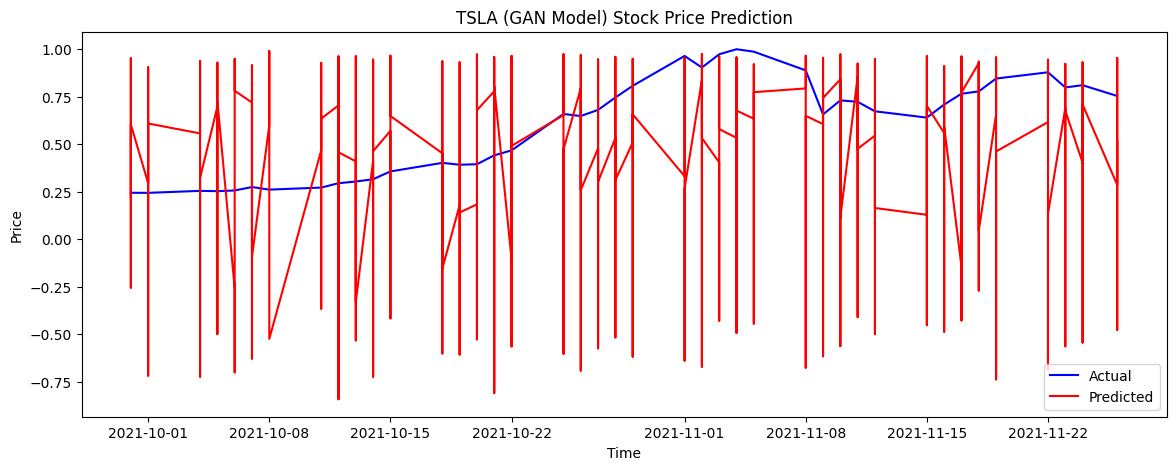

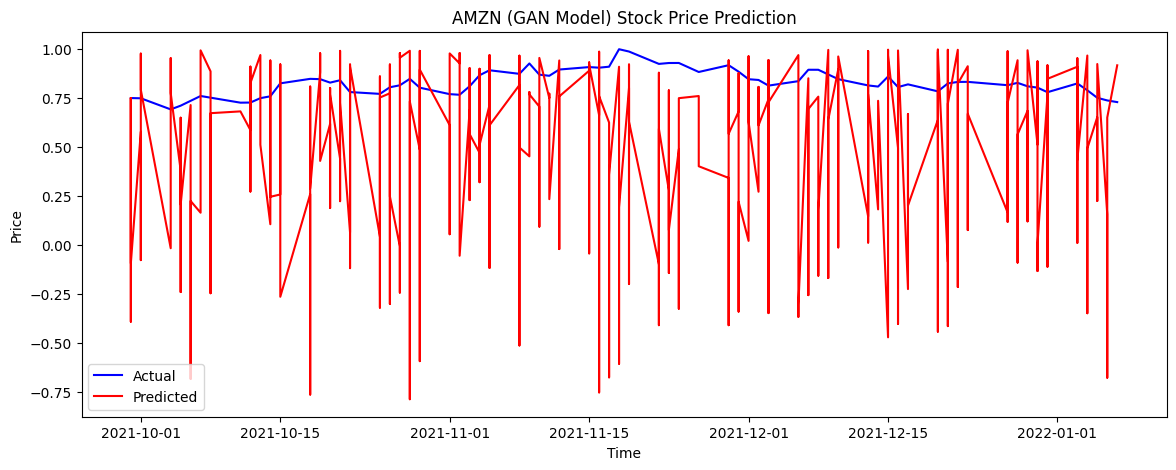

In [ ]:
# Plot the predictions
plot_predictions(y_test_tsla, gan_pred_tsla, 'TSLA (GAN Model)', dates_test_tsla)
plot_predictions(y_test_amzn, gan_pred_amzn, 'AMZN (GAN Model)', dates_test_amzn)

By time steps

In [ ]:
#for TSLA
def random_search_2(iterations, search_space):
    best_mse = float('inf')
    best_hyperparams = None

    for _ in range(iterations):
        # Randomly select hyperparameters from search_space
        hyperparams = {
            key: random.choice(values) for key, values in search_space.items()
        }

        print(f'Training with hyperparameters: {hyperparams}')

        # Train and evaluate GAN model with the selected hyperparameters
        mse = train_gan_with_hyperparameters(hyperparams, X_train_tsla2, y_train_tsla2, X_test_tsla2, y_test_tsla2)[0]

        # Update the best hyperparameters if necessary
        if mse < best_mse:
            best_mse = mse
            best_hyperparams = hyperparams

        print(f'Current best hyperparameters: {best_hyperparams}')
        print(f'Current best MSE: {best_mse}')

    return best_hyperparams

# Perform random search
iterations = 5
best_hyperparams_2 = random_search_2(iterations, search_space)

print(f'Best hyperparameters: {best_hyperparams_2}')


Training with hyperparameters: {'learning_rate': 0.05, 'batch_size': 128, 'num_layers': 2, 'num_units': 256}
4/4 [==============================] - 0s 2ms/step
Epoch 1: Discriminator loss: 5.0878, Generator loss: 14.2272
4/4 [==============================] - 0s 2ms/step
Epoch 2: Discriminator loss: 98.1507, Generator loss: 54.6599
4/4 [==============================] - 0s 2ms/step
Epoch 3: Discriminator loss: 66.6708, Generator loss: 198.6302
4/4 [==============================] - 0s 2ms/step
Epoch 4: Discriminator loss: 0.5724, Generator loss: 98.3901
4/4 [==============================] - 0s 2ms/step
Epoch 5: Discriminator loss: 4.1551, Generator loss: 167.0616
4/4 [==============================] - 0s 2ms/step
Epoch 6: Discriminator loss: 0.1189, Generator loss: 107.5216
4/4 [==============================] - 0s 2ms/step
Epoch 7: Discriminator loss: 0.1181, Generator loss: 66.9217
4/4 [==============================] - 0s 2ms/step
Epoch 8: Discriminator loss: 0.7333, Generator loss

In [ ]:
#For AMZN
def random_search2_2(iterations, search_space):
    best_mse = float('inf')
    best_hyperparams = None

    for _ in range(iterations):
        # Randomly select hyperparameters from search_space
        hyperparams = {
            key: random.choice(values) for key, values in search_space.items()
        }

        print(f'Training with hyperparameters: {hyperparams}')

        # Train and evaluate GAN model with the selected hyperparameters
        mse = train_gan_with_hyperparameters(hyperparams, X_train_amzn2, y_train_amzn2, X_test_amzn2, y_test_amzn2)[0]

        # Update the best hyperparameters if necessary
        if mse < best_mse:
            best_mse = mse
            best_hyperparams = hyperparams

        print(f'Current best hyperparameters: {best_hyperparams}')
        print(f'Current best MSE: {best_mse}')

    return best_hyperparams

# Perform random search
iterations = 5
best_hyperparams2_2 = random_search2_2(iterations, search_space)

print(f'Best hyperparameters: {best_hyperparams2_2}')

Training with hyperparameters: {'learning_rate': 0.05, 'batch_size': 64, 'num_layers': 3, 'num_units': 128}
2/2 [==============================] - 0s 4ms/step
Epoch 1: Discriminator loss: 1.5655, Generator loss: 37.4244
2/2 [==============================] - 0s 4ms/step
Epoch 2: Discriminator loss: 181.2373, Generator loss: 37.7108
2/2 [==============================] - 0s 6ms/step
Epoch 3: Discriminator loss: 136.3692, Generator loss: 60.2878
2/2 [==============================] - 0s 4ms/step
Epoch 4: Discriminator loss: 0.1824, Generator loss: 129.3290
2/2 [==============================] - 0s 5ms/step
Epoch 5: Discriminator loss: 5.0892, Generator loss: 85.6602
2/2 [==============================] - 0s 5ms/step
Epoch 6: Discriminator loss: 6.2198, Generator loss: 25.9155
2/2 [==============================] - 0s 4ms/step
Epoch 7: Discriminator loss: 4.5295, Generator loss: 27.2928
2/2 [==============================] - 0s 7ms/step
Epoch 8: Discriminator loss: 8.3148, Generator loss:

In [ ]:
mse_tsla2, trained_generator_tsla2 = train_gan_with_hyperparameters(best_hyperparams_2, X_train_tsla2, y_train_tsla2, X_test_tsla2, y_test_tsla2)
mse_amzn2, trained_generator_amzn2 = train_gan_with_hyperparameters(best_hyperparams2_2, X_train_amzn2, y_train_amzn2, X_test_amzn2, y_test_amzn2)

1/1 [==============================] - 0s 58ms/step
Epoch 1: Discriminator loss: 0.7041, Generator loss: 0.7210
1/1 [==============================] - 0s 16ms/step
Epoch 2: Discriminator loss: 0.3892, Generator loss: 0.6180
1/1 [==============================] - 0s 18ms/step
Epoch 3: Discriminator loss: 0.2811, Generator loss: 0.6756
1/1 [==============================] - 0s 17ms/step
Epoch 4: Discriminator loss: 0.2832, Generator loss: 0.6325
1/1 [==============================] - 0s 20ms/step
Epoch 5: Discriminator loss: 0.3011, Generator loss: 0.6605
1/1 [==============================] - 0s 16ms/step
Epoch 6: Discriminator loss: 0.3248, Generator loss: 0.6328
1/1 [==============================] - 0s 17ms/step
Epoch 7: Discriminator loss: 0.3034, Generator loss: 0.6539
1/1 [==============================] - 0s 16ms/step
Epoch 8: Discriminator loss: 0.3518, Generator loss: 0.6517
1/1 [==============================] - 0s 16ms/step
Epoch 9: Discriminator loss: 0.4050, Generator loss:

In [ ]:
# Generate predictions for TSLA
gan_pred_tsla2 = trained_generator_tsla2.predict(np.random.normal(0, 1, (X_test_tsla2.shape[0], latent_dim)))[:, -1, 0]

# Generate predictions for AMZN
gan_pred_amzn2 = trained_generator_amzn2.predict(np.random.normal(0, 1, (X_test_amzn2.shape[0], latent_dim)))[:, -1, 0]

# Print the Mean Squared Errors
print(f"MSE for TSLA predictions/time steps: {mse_tsla2}")
print(f"MSE for AMZN predictions/time steps: {mse_amzn2}")

21/21 [==============================] - 0s 2ms/step
MSE for TSLA predictions/time steps: 0.21457118688736987
MSE for AMZN predictions/time steps: 0.04097069277416326


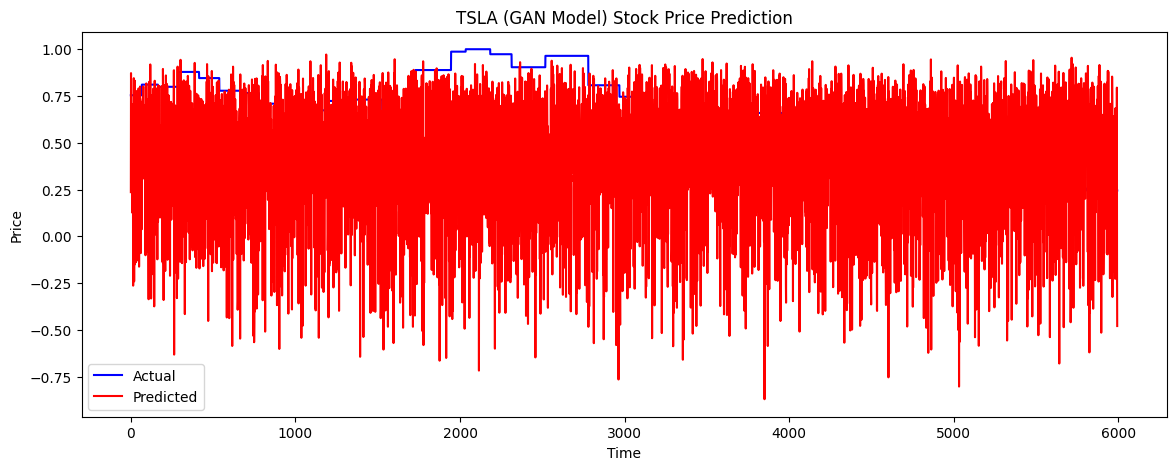

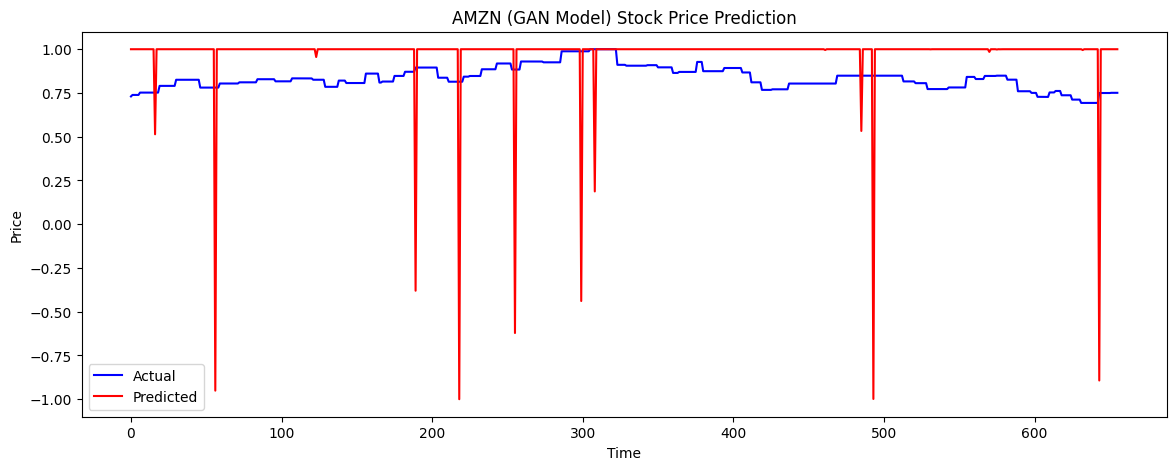

In [ ]:
# Plot the predictions
plot_predictions2(y_test_tsla2, gan_pred_tsla2, 'TSLA (GAN Model)')
plot_predictions2(y_test_amzn2, gan_pred_amzn2, 'AMZN (GAN Model)')